# Importazione SHAP
**SHAP (SHapley Additive exPlanations)** è uno strumento molto potente nell’ambito della Explainable AI che viene utilizzato per interpretare e spiegare i modelli di machine learning. La sua idea principale è quella di spiegare come ogni singola feature contribuisce alla previsione di un modello per ogni singola istanza.

In [ ]:
! pip install shap

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

##DeepExplainer##
DeepExplainer è progettato per modelli deep learning, come reti neurali (sia quelle addestrate con Keras, TensorFlow, che PyTorch). È un'implementazione di SHAP che funziona specificamente con reti neurali, cercando di spiegare come ogni caratteristica contribuisce alla previsione di un modello neurale.

DeepExplainer utilizza un approccio basato sull'approssimazione del gradiente per calcolare i valori SHAP nei modelli di deep learning. L'algoritmo funziona calcolando le derivate dei modelli rispetto agli input, quindi applica i valori di Shapley per ottenere i contributi di ciascun nodo (caratteristica) alla previsione finale.

Il vantaggio è che permette di spiegare modelli complessi come le reti neurali profonde, che sono altrimenti difficili da interpretare.

In [27]:
# importazioni librerire
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [70]:
# caricamento dataset mnist di keras : numeri (0-9) di 28x28 pixel in scala di grigi (0-255, 0: nero, 255: bianco)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [71]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first': # image_data_format() restituisce il formato utilizzato per le immagini nel framework.
    # dimensione dell'immagine organizzata come (canali, altezza, larghezza) (1x28x28).
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) # x_train.shape[0] numero di img nel training set
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [72]:
# convertiamo i valori dei pixel da interi a float32 (formato standard per input nei modelli di deep learning)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalizziamo i valori dei pixel in modo che siano nell'intervallo [0,1]
x_train /= 255
x_test /= 255

# formato traning set
print('x_train shape:', x_train.shape)

# numero di esempi di training
print(x_train.shape[0], 'train samples')

# numero di esempi di testing
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [73]:
# one hot encoding
num_classes = 10 # numeri da 0 a 9 -> 10 classi

# convertiamo le etichette in vettori binari dove 9 valori saranno 0 e l'etichetta in posizione corrispondente 1 (utile per la classificazione softmax)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# definiamo il modello CNN
model = Sequential()

# aggiugniamo un layer convoluzionale con 32 filtri, ognuno di dimensione 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# aggiugniamo un layer convoluzionale con 64 filtri, ognuno di dimensione 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))

# aggiungiamo un layer di pooling per ridurre le dimensioni delle img, prendendo il max valore in finestre 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# aggiungiamo il droput con valroe 0.25 : disattiva casualmente il 25% dei neuroni per ogni batch.
model.add(Dropout(0.25))

# trasformiamo l'output 2D ottenuto in un vettore 1D
model.add(Flatten())

# aggiungiamo un layer denso (neuroni totalmente connessi tra loro) con 128 neuroni, che elabora le feature per la classificazione finale.
model.add(Dense(128, activation='relu'))

# aggiungiamo il droput con valroe 0.5 : disattiva casualmente il 50% dei neuroni per ogni batch.
model.add(Dropout(0.5))

# aggiungiamo l'output layer con 10 nueroni (10 classi) e funzione di attivazione softmax per la classificazione
model.add(Dense(num_classes, activation='softmax'))

# stampiamo la struttura del modello costruito
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(loss=keras.losses.categorical_crossentropy, # funzione di loss usata per classificazione multi-classe
              optimizer=keras.optimizers.Adadelta(), # ottimizzatore che regola i pesi durante il training
              metrics=['accuracy'])  # metrica da monitorare

In [75]:
# addestramento
batch_size = 128
epochs = 2

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 148s 313ms/step - accuracy: 0.1024 - loss: 2.3024 - val_accuracy: 0.2781 - val_loss: 2.2419
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 311ms/step - accuracy: 0.2188 - loss: 2.2345 - val_accuracy: 0.4889 - val_loss: 2.1599


In [76]:
# valutiamo il modello sul test set
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# per salvare il modello in modo da non doverlo riaddestrare
from keras.models import load_model
model.save('mnist_cnn_model.h5')

Test loss: 2.1598849296569824
Test accuracy: 0.48890000581741333


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


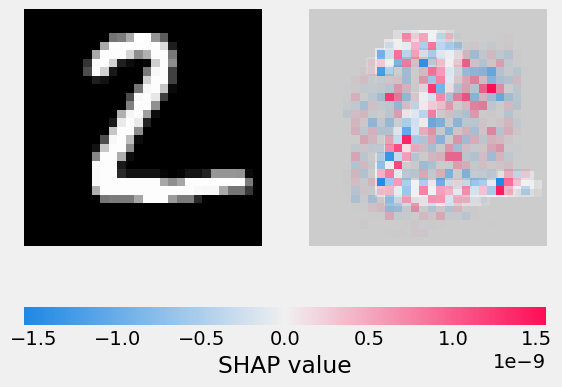

In [94]:
import shap
import numpy as np
from keras.datasets import mnist

# caricamento dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# pre processing
from keras import backend as K
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# stampiamo le dimensioni
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# per caricare il modello già addestrato
from keras.models import load_model
model = load_model('mnist_cnn_model.h5')

"""
Nel contesto di SHAP, il background è un insieme di dati su cui calcolare la valutazione media del modello.
Serve come punto di riferimento per determinare quanto ciascun input cambia l’output del modello.
In particolare, SHAP calcola i contributi comparando l’output del modello per un dato esempio
con l’output che si otterrebbe usando valori "mancanti" (approssimati dal background).
"""

# selezioniamo un insieme di 100 esempi di background su cui prendere in considerazione un'aspettativa
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# definiamo il modello DeepExplainer
e = shap.DeepExplainer(model, background)

# spieghiamo le previsione del modello per la prima img del test set
shap_values = e.shap_values(x_test[1:2])

"""
shap_values sarà una lista di array, uno per ogni classe (0–9), perché il modello ha 10 output (softmax per le 10 cifre).
Per ogni pixel in ogni immagine, SHAP stima quanto ha contribuito quella posizione alla probabilità assegnata a una certa classe.

Per ogni immagine mostrata sarà visualizata la predizione originale, ed una una mappa di calore che mostra l’influenza dei pixel, dove :
- i pixel di colore rosso (positivo) indicano pixel che hanno supportato la predizione del modello
- i pixel di colore blu (negativo) indicano i pixel che vanno contro la predizione
- i pixel trasparenti/neutri indicano i pixel che hanno un'influenza minima sulla predizione

"""

#  visualizza i contributi pixel-per-pixel in forma visiva.
shap.image_plot(shap_values, x_test[1:2])

##**KernelExplainer**##

Implementazione di Kernel SHAP, un metodo agnostico per stimare i valori SHAP per qualsiasi modello. Poiché non fa ipotesi sul tipo di modello, KernelExplainer è più lento rispetto agli altri algoritmi specifici per il tipo di modello.

Classificazione dell'iris - Una dimostrazione di base che utilizza il popolare dataset delle specie di iride. Spiega le previsioni di sei diversi modelli in scikit-learn utilizzando SHAP.

Qui utilizziamo il noto dataset della specie Iris per illustrare come SHAP possa spiegare l'output di molti diversi tipi di modelli, dai k-nearest neighbors alle reti neurali.

Questo dataset è molto piccolo, con soli 150 campioni. Utilizziamo un insieme casuale di 130 per l'addestramento e 20 per il test dei modelli. Poiché si tratta di un dataset piccolo con solo poche caratteristiche, utilizziamo l'intero dataset di addestramento come contesto. In problemi con più featues, vorremmo passare solo la mediana del dataset di addestramento, o k-mediane pesate.

Pur avendo solo pochi campioni, il problema di previsione è abbastanza semplice e tutti i metodi raggiungono un'accuratezza perfetta. La cosa interessante è come metodi diversi a volte si basino su insiemi diversi di caratteristiche per le loro previsioni.

In [85]:
# importazione librerie
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time
import pandas as pd

# caricamento dataset iris e divisione dati in 80% di training e 20% di testing
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

# invece di usare l'intero training set per stimare i valori attesi, potremmo riassumerlo con un insieme di kmeans pesati,
# ognuno pesato dal numero di punti che rappresenta. Ma questo dataset è cosi piccolo che non abbiamo bisogno di preoccuparci
# X_train_summary = shap.kmeans(X_train, 50)

# funzione per stampare l'accuracy del modello addestrato
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # per stampare prima di qualsiasi barra di avanzamento

In [86]:
# definiamo il modello di Regressione Logistica di sklearn
linear_lr = sklearn.linear_model.LogisticRegression()

# addestriamo il modello
linear_lr.fit(X_train, Y_train)

# stampiamo l'accuracy
print_accuracy(linear_lr.predict)

Accuracy = 100.0%


In [ ]:
# inizializzazione js per la visualizzazione
shap.initjs()

# salviamo i nomi delle feature
feature_names = X_train.columns

f = lambda x: linear_lr.predict_proba(pd.DataFrame(x, columns=feature_names))[:, 0]  # per la classe 0 (setosa) del dataset iris
# analogamente si potrebbe rifare per le altri classi 1, 2 (versicolor, virginica).

# definiamo il modello KernelExplainer, che si basa su una stima kernel che approssima i valori SHAP usando la funzione di predizione predict_proba.
explainer = shap.KernelExplainer(f, X_train)

#  spieghiamo tutte le predizioni effettuare del test set
# Per ogni istanza di X_test, calcoliamo gli SHAP values per ogni feature.
# ci darà quanto ogni singola feature ha contribuito a cambiare la probabilità rispetto alla media
shap_values = explainer.shap_values(X_test)

shap.force_plot(explainer.expected_value, shap_values, X_test)

##**TreeExplainer**##

Sebbene i valori SHAP possano spiegare l'output di qualsiasi modello di ML, è stato sviluppato un algoritmo ad alta velocità per metodi di ensemble ad albero (articolo Tree SHAP su arXiv). Sono supportate implementazioni C++ veloci per modelli ad albero XGBoost, LightGBM, CatBoost e scikit-learn:

In [96]:
# importazione librerie
import xgboost
import shap
import os
import pandas as pd

In [97]:
# caricamento dataset
path = os.getcwd()
path_dataset = 'drive/MyDrive/Colab Notebooks/Datasets' #Put path of dataset

path_ = os.path.join(path, path_dataset, 'boston.csv')
data = pd.read_csv(path_)

# divisione dei dati in 70% di training e 30% di testing
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:-1], data.iloc[:, -1], test_size=0.3, shuffle=True, random_state=42)

In [98]:
# addestramento modello XGBoost
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

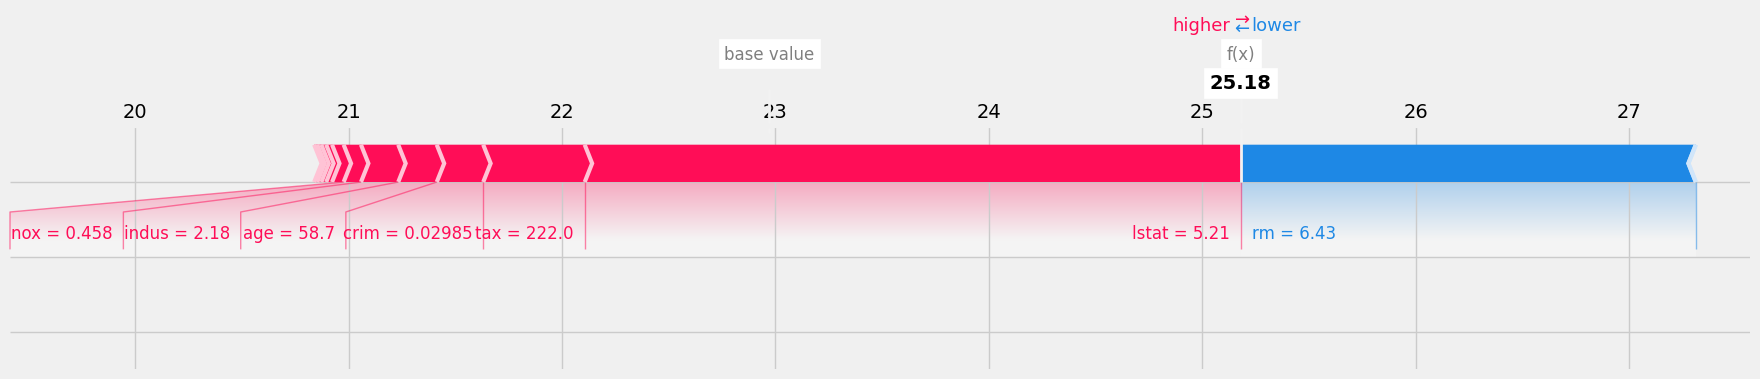

In [100]:
# inizializzazione js per la visualizzazione
shap.initjs()

# definiamo il modello TreeExplainer
explainer = shap.TreeExplainer(model)

# spiegazione delle predizioni del modello usando i valori SHAP (la sintassi è similer per gli altri modelli LightGBM, CatBoost, e quelli di scikit-learn)
shap_values = explainer.shap_values(X_train)

# visualizziamo la spiegazione della prima predizione effettuata
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:]) # (per usare matplotlib e non js aggiungere matplotlib=True)

##**Esempio : Red Wine Quality**##

In [101]:
# importazione librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

# cambia lo stile dei grafici in matplotlib
plt.style.use('fivethirtyeight')

# per mostare i grafici direttamente nella cella del notebook
%matplotlib inline

In [102]:
# caricamento dataset
path_dataset = 'drive/MyDrive/Colab Notebooks/Datasets/'
df_raw = pd.read_csv(path_dataset+'winequality-red.csv')

# copia di sicurezza del dataset originale
wines = df_raw.copy()

# stampiamo le dimensioni
df_raw.shape

(1599, 12)

In [103]:
# estraiamo la variabile target dal dataset e creiamo una lista delle variabili dipendenti
target = 'quality'
features_list = list(wines.columns)
features_list.remove(target)

In [104]:
# creiamo il vettore target
y = wines.pop('quality')

# binarizziamo y (i valori minori o uguali a 5 diventano 0, altrimenti 1)
y = y.apply(lambda x: 0 if x <= 5 else 1)


# controlliamo che abbiamo una partiziona del target bilanciata
y.sum() / len(y)

np.float64(0.5347091932457786)

In [105]:
# dividiamo i dati in 70% di training e 30% di testing
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=33)

# stampiamo le dimensioni
X_train.shape, X_test.shape

((1119, 11), (480, 11))

In [106]:
# definiamo il modello xgboost
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)

# addestriamo il modello
%time xgb.fit(X_train, y_train)

CPU times: user 551 ms, sys: 2.03 ms, total: 553 ms
Wall time: 640 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=33, ...)

In [107]:
# effettuiamo le predizioni per il test set con il modello addestrato
xgb_predictions = xgb.predict(X_test)

In [108]:
# funzione di valutazione, stampa l'accuracy del modello sul test set, il report di classificazione e la matrice di confusione
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4) * 100, '%')
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction))
    print('confusione matrix:\n\n', metrics.confusion_matrix(y_true=test, y_pred=prediction))

In [109]:
# valutiamo il modello addestrato
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 77.08 %
------------------------------------------------------------
classification report:

               precision    recall  f1-score   support

           0       0.74      0.78      0.76       221
           1       0.80      0.76      0.78       259

    accuracy                           0.77       480
   macro avg       0.77      0.77      0.77       480
weighted avg       0.77      0.77      0.77       480

confusione matrix:

 [[172  49]
 [ 61 198]]


### Model Interpretation with SHAP

In [110]:
# definiamo il modello TreeExplainer
explainer = shap.TreeExplainer(xgb)

# spiegazione delle predizioni del modello sul test set usando i valori SHAP
# (la sintassi è similer per gli altri modelli LightGBM, CatBoost, e quelli di scikit-learn)
shap_values = explainer.shap_values(X_test)

# stampiamo il valore atteso (valore medio delle predizioni prima di vedere i dati, ossia senza nessuna feature)
# rappresenta la baseline prediction, ovvero cosa predirebbe il modello se non avesse alcuna informazione sulle features.
print('Expected Value: ', explainer.expected_value)

Expected Value:  0.13355194


###Feature Importances with SHAP

In [ ]:
# inizializzazione js per la visualizzazione
shap.initjs()

# visualizziamo il grafico della feature importance, che mostrerà quanto ogni features ha influito (in valore assoluto) sulle predizioni
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')

Predicting when a particular wine quality will be <= 5 ('Low Quality')

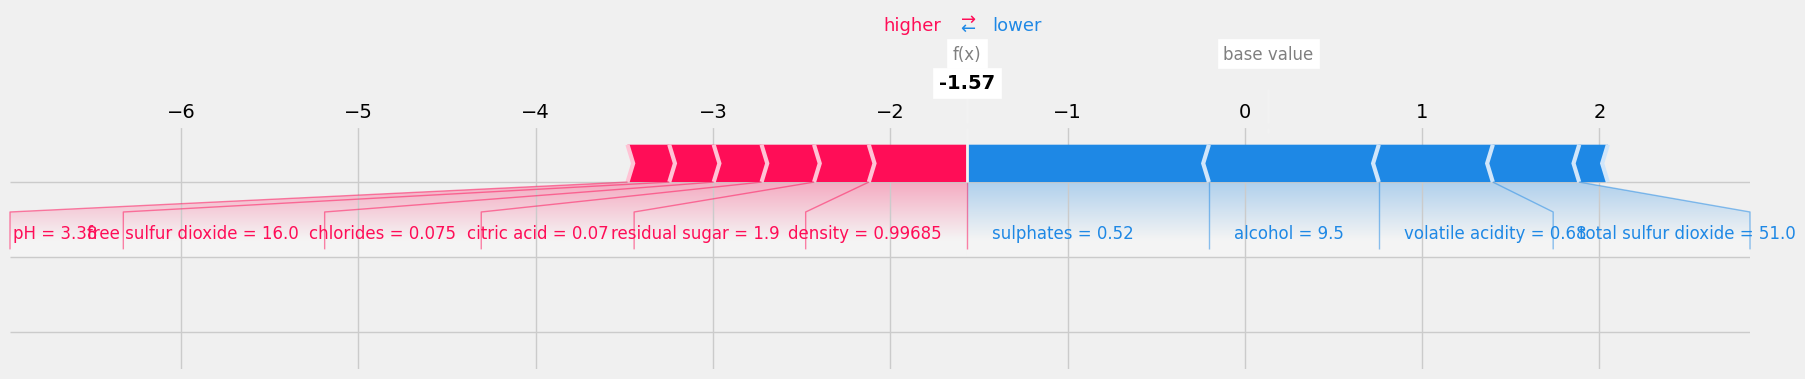

In [114]:
shap.initjs()

# visualizziamo il force plot, per il primo esempio di test, che mostrerà quanto ogni feature ha influito negativamente e positivamente sulla predizione
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],matplotlib=True)

Predicting when a particular wine quality will be > 5 ('Hight Quality')

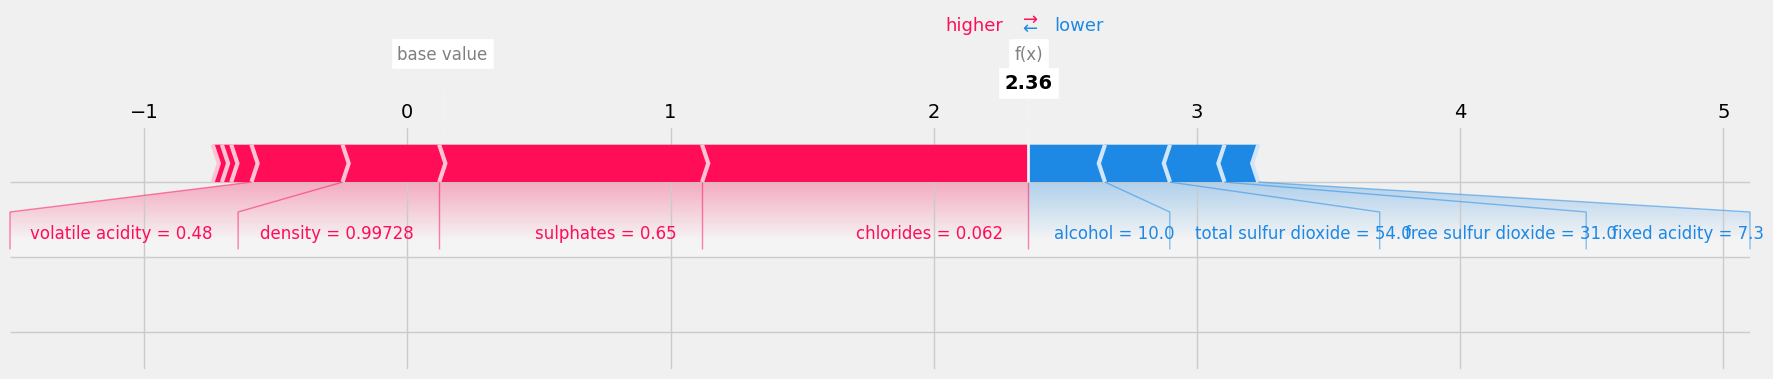

In [115]:
shap.initjs()

# visualizziamo il force plot, per il quinto esempio di test
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:],matplotlib=True)

In [ ]:
shap.initjs()

# visualizziamo il force plot, per più predizioni (i primi 1000 esempi del test set) anzichè per singole predizioni
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

**SHAP Summary Plot**

In [ ]:
shap.initjs()

# visualizzazione del summory plot, dove sull'asse y ci sono le features ordinate in modo decrescente di importanza,
# sull'asse x sono rappresentati i valori shap, ovvero quanto le feature hanno spinto la predizione,
# e dove ogni punto rappresenta una predizione per una singola feature
shap.summary_plot(shap_values, X_test)

### SHAP Dependence Plots
PD plot of 'pH' (and influence of 'fixed acidity') affecting model prediction

In [ ]:
# visualizziamo un dependence plot per la feature pH, osservando come viene influenzata dalla variabile fixed acidity

shap.dependence_plot(ind='pH', # variabile principale per il grafico di dipendenza, il grafico mostrerà come il valore di 'pH' influisce sui valori SHAP
                     interaction_index='fixed acidity', # il grafico mostrerà anche come 'fixed acidity' interagisce con 'pH' nel determinare la predizione.
                     shap_values=shap_values, # valori SHAP calcolati per il test set, che descrivono come ogni feature ha influenzato la predizione.
                     features=X_test, # passiamo le features di input di test, per far sapere quali valori di feature sono associati a ciascun valore SHAP.
                     display_features=X_test) # e anche per visualizzare i valori delle feature nel grafico

# il grafico mostra sull'asse x la feature pH, sull'asse y l'influenza di pH sulla predizione ovvero i valori shap
# ogni punto nel grafico rappresenta un'osservazione nel test set, ed il colore di ogni punto rappresenta il valore di fixed acidity
# (l'interazione tra 'pH' e 'fixed acidity'), utile per vedere se c'è qualche tipo di pattern o correlazione tra le due feature.